# Loading necessary libraries

In [103]:
# System imports
import sys
import importlib
from pathlib import Path

# Visualization imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Project setup
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Project modules
MODULES = [
    'iowa_dream.data',
    'iowa_dream.data.importer',
    'iowa_dream.data.loader', 
    'iowa_dream.utils.plotting_EDA',
    'iowa_dream.utils.describer',
    'iowa_dream.data.cleaner',
    'iowa_dream.utils.inconsistency_check'
]

# Reload modules
for module in MODULES:
    if module in sys.modules:
        importlib.reload(sys.modules[module])
    else:
        __import__(module)

# Project imports
from iowa_dream.data.importer import load_config
from iowa_dream.data.loader import preliminary_loader
from iowa_dream.utils.describer import (
    categorical_describer,
    numerical_describer, 
    analyze_categorical_sparsity
)
from iowa_dream.utils.plotting_EDA import (
    plot_missing_data_heatmap,
    box_plot_dist,
    output_distribution_plotting,
    plot_target_over_time,
    interactive_feature_distribution_plots,
    plot_price_vs_sale_condition,
    interactive_feature_target_distribution_plots,
    plot_cramer_v_associations,
    anova_categorical_feature_importance,
    plot_numerical_correlation_matrix
)
from iowa_dream.data.cleaner import (
    simple_fill_missing_by_keywords,
    garage_imputer,
    type_formatting
)
from iowa_dream.utils.inconsistency_check import (
    report_inconsistent_years,
    consistency_missing_type_area
)

# 0. Preliminary Load

In [104]:
# Example usage
data_file = project_root / load_config()['kaggle']['download_path'] / 'AmesHousing.csv'
# In this loader, we have standardized column names by replacing spaces with underscores, 
# converting to lowercase, 
# and applying specific replacements such as 'yr' to 'year', 
# 'qual' or 'qc' to 'qu' (quality), 
# 'abvgrd' to 'abvgr' (above grade), and 
# 'built' to 'blt' (built).
df = preliminary_loader(data_file)

In [105]:
# Extract feature column names for different data types
data_dict = load_config()['data_dict']
ordinal = data_dict['ordinal_columns']['columns']
nominal = data_dict['nominal_columns']['columns']
continuous = data_dict['continuous_columns']['columns']
discrete = data_dict['discrete_columns']['columns']

#1. Some EDAs on the Target of `saleprice`

In [106]:
numerical_describer(df, ['saleprice'])


Numerical Columns Summary:
Total numerical columns: 1
Columns with missing values: 0


,Total Missing,Percent Missing,Data Type,Value Information,Mean,Std Dev,Min,25%,50%,75%,Max
saleprice,0,0.0,int64,Range: 12789 to 755000 (1032 unique values),180796.060068,79886.692357,12789,129500.0,160000.0,213500.0,755000


Comment: No missing values but seems to disperse a lot. 


Price Range Distribution (%):
saleprice
<$100k          8.6
$100k-$200k    62.2
$200k-$300k    21.4
$300k-$400k     5.7
>$400k          2.2

Normality Tests (α = 0.1):
              Test  Test Statistic       p-value    Result
D'Agostino-Pearson     1074.646596 4.400040e-234 Reject H₀
      Shapiro-Wilk        0.876261  2.334909e-43 Reject H₀
  Anderson-Darling       87.367435           NaN Reject H₀
       Jarque-Bera     4668.421409  0.000000e+00 Reject H₀

Fat-Tailed Tests (α = 0.1):
    Test  Test Statistic  Reference Value     Result
Kurtosis        8.108122              3.0 Fat-tailed


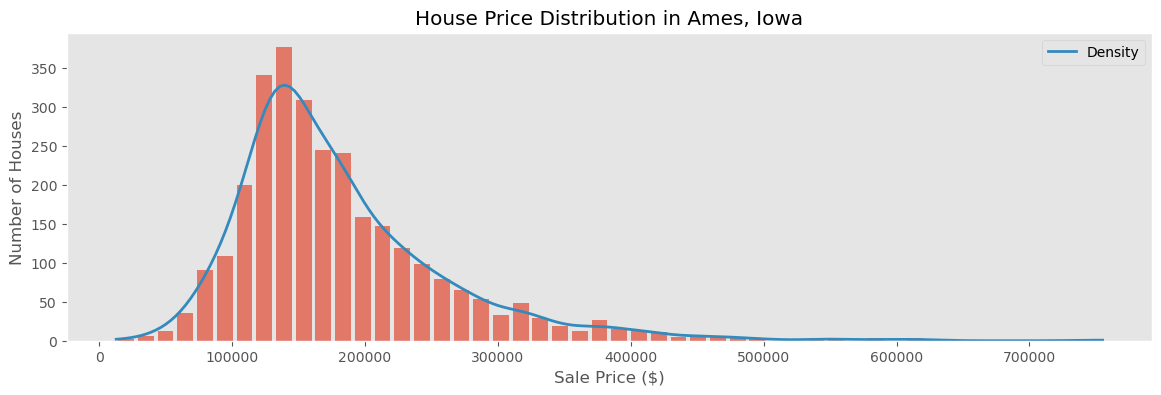

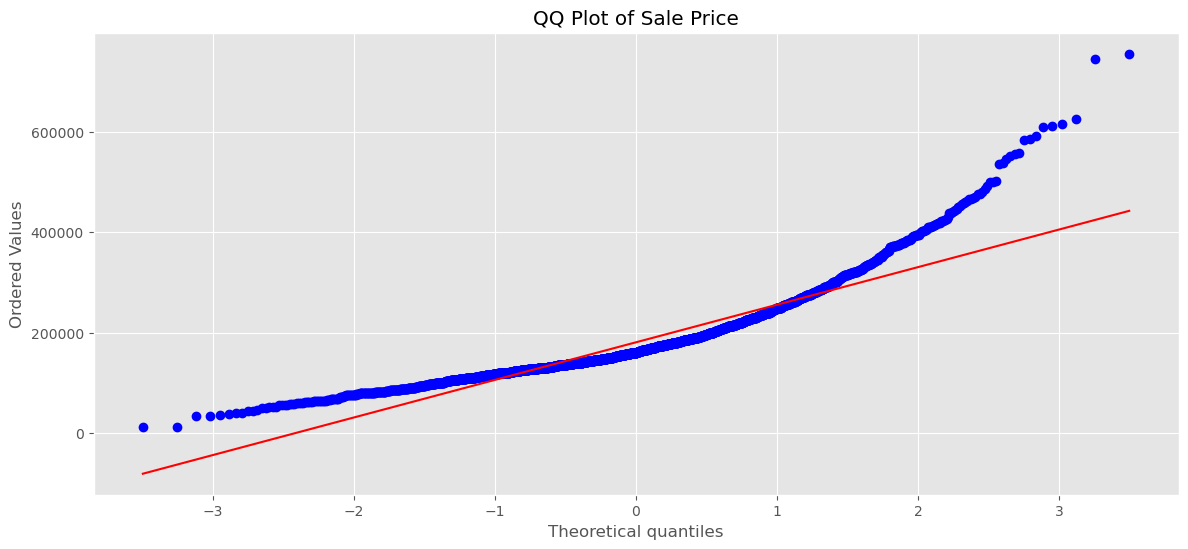

In [107]:
output_distribution_plotting(df, target_col='saleprice')

Comment: Overall, the distribution seems to be skewed and have fat-failed. Furthermore, there are some values that are extreme outliers, beyond 500,000 for example.

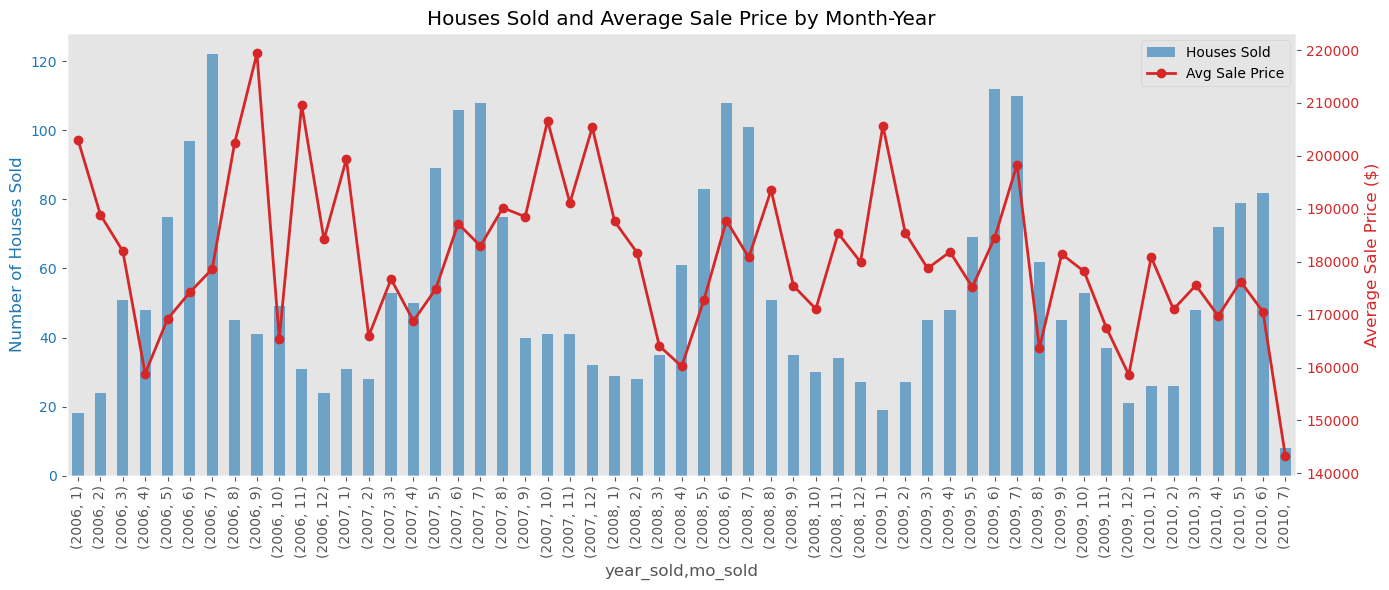

In [108]:
# Plot the number of houses sold and average sale price over time to analyze trends
# Shows both volume of sales and price changes month by month
plot_target_over_time(df, target_col='saleprice', year_col='year_sold', month_col='mo_sold')

Comment: Interesting to see some seasonal patterns. The number of houses sold is highest in the summer months and the average sale price tends to higher in the second half of the year. 


### Outliers

"There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately)." - Author of the dataset

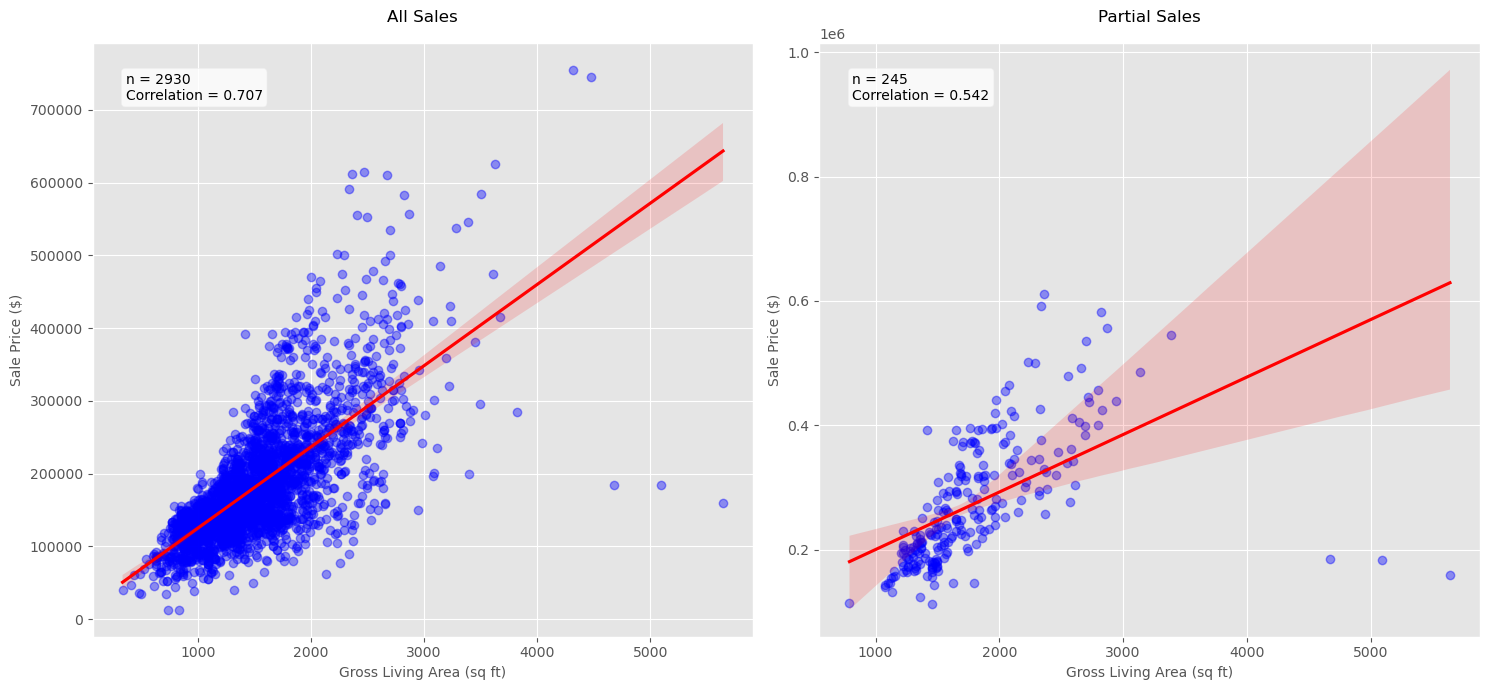

In [109]:
# Example usage:
plot_price_vs_sale_condition(df, sale_conditions=['Partial'])

Comment: We will drop the three observations that are true outliers where it does not represent actual market values. The two observations with higher prices can contain information about the market (special house features etc.) and we will keep them, while accounting for this in the models' loss function.

In [110]:
# Filter out the outliers where gr_liv_area > 4000 and saleprice < 200000
df = df[~((df.gr_liv_area > 4000) & (df.saleprice < 200000))]

#2. Feature Description

In [111]:
categorical_describer(df, nominal)


Categorical Columns Summary:
Total categorical columns: 23
Columns with missing values: 4


,Total Missing,Percent Missing,Data Type,Value Information,Mode,Mode Frequency
misc_feature,2822,0.964127,object,"4 unique values: Gar2, Othr, Shed, TenC",Shed,95
alley,2729,0.932354,object,"2 unique values: Grvl, Pave",Grvl,120
mas_vnr_type,1775,0.606423,object,"4 unique values: BrkCmn, BrkFace, CBlock, Stone",BrkFace,880
garage_type,157,0.053639,object,"6 unique values: 2Types, Attchd, Basment, Buil...",Attchd,1729
roof_matl,0,0.000000,object,"7 unique values: CompShg, Membran, Metal, Roll...",CompShg,2885
sale_condition,0,0.000000,object,"6 unique values: Abnorml, AdjLand, Alloca, Fam...",Normal,2413
sale_type,0,0.000000,object,"10 unique values: COD, CWD, Con, ConLD, ConLI,...",WD,2536
central_air,0,0.000000,object,"2 unique values: N, Y",Y,2731
heating,0,0.000000,object,"6 unique values: Floor, GasA, GasW, Grav, OthW...",GasA,2882
foundation,0,0.000000,object,"6 unique values: BrkTil, CBlock, PConc, Slab, ...",PConc,1307


Comment: `ms_subclass` should be reformatted to be a categorical variable because it indicates building class. We will take notes of this for **preprocessing** 

In [112]:
categorical_describer(df, ordinal)


Categorical Columns Summary:
Total categorical columns: 23
Columns with missing values: 12


,Total Missing,Percent Missing,Data Type,Value Information,Mode,Mode Frequency
pool_qu,2915,0.995900,object,"4 unique values: Ex, Fa, Gd, TA",Ex,4
fence,2355,0.804578,object,"4 unique values: GdPrv, GdWo, MnPrv, MnWw",MnPrv,330
fireplace_qu,1422,0.485822,object,"5 unique values: Ex, Fa, Gd, Po, TA",Gd,741
garage_cond,159,0.054322,object,"5 unique values: Ex, Fa, Gd, Po, TA",TA,2662
garage_qu,159,0.054322,object,"5 unique values: Ex, Fa, Gd, Po, TA",TA,2612
garage_finish,159,0.054322,object,"3 unique values: Fin, RFn, Unf",Unf,1231
bsmt_exposure,83,0.028357,object,"4 unique values: Av, Gd, Mn, No",No,1906
bsmtfin_type_2,81,0.027673,object,"6 unique values: ALQ, BLQ, GLQ, LwQ, Rec, Unf",Unf,2496
bsmt_cond,80,0.027332,object,"5 unique values: Ex, Fa, Gd, Po, TA",TA,2613
bsmt_qu,80,0.027332,object,"5 unique values: Ex, Fa, Gd, Po, TA",TA,1283


The scale for quality and condition is: Ex - Excellent, Gd - Good, TA - Average/Typical, Fa - Fair, Po - Poor. Ordinal encoding can apply to this scale for `pool_qu`, `fireplace_qu`, `garage_cond`, `garage_qu`, `bsmt_cond`, `bsmt_qu`, `heating_qu`, `kitchen_qu`, `exter_cond`, `exter_qu`. Significant missing values exist for `pool`, `fireplace`, and `fence` quality. 

In [113]:
numerical_describer(df, continuous)


Numerical Columns Summary:
Total numerical columns: 19
Columns with missing values: 7


,Total Missing,Percent Missing,Data Type,Value Information,Mean,Std Dev,Min,25%,50%,75%,Max
lot_frontage,490,0.167407,float64,Range: 21.0 to 313.0 (129 unique values),69.075503,22.787266,21.0,58.0,68.0,80.0,313.0
mas_vnr_area,23,0.007858,float64,Range: 0.0 to 1600.0 (444 unique values),101.044077,177.098747,0.0,0.0,0.0,164.0,1600.0
bsmtfin_sf_1,1,0.000342,float64,Range: 0.0 to 2288.0 (993 unique values),439.011620,439.355775,0.0,0.0,370.0,734.0,2288.0
bsmtfin_sf_2,1,0.000342,float64,Range: 0.0 to 1526.0 (275 unique values),49.773411,169.247708,0.0,0.0,0.0,0.0,1526.0
bsmt_unf_sf,1,0.000342,float64,Range: 0.0 to 2336.0 (1138 unique values),559.005810,439.569050,0.0,219.0,464.5,801.0,2336.0
total_bsmt_sf,1,0.000342,float64,Range: 0.0 to 3206.0 (1056 unique values),1047.790841,422.493494,0.0,793.0,990.0,1300.0,3206.0
garage_area,1,0.000342,float64,Range: 0.0 to 1488.0 (602 unique values),472.123377,213.939485,0.0,320.0,480.0,576.0,1488.0
open_porch_sf,0,0.000000,int64,Range: 0 to 742 (249 unique values),47.178340,66.551515,0.0,0.0,27.0,70.0,742.0
pool_area,0,0.000000,int64,Range: 0 to 800 (13 unique values),2.081654,34.502476,0.0,0.0,0.0,0.0,800.0
screen_porch,0,0.000000,int64,Range: 0 to 576 (121 unique values),16.018449,56.113774,0.0,0.0,0.0,0.0,576.0


Comment: Some features indicate a lot of large variations like `misc_val`, i.e. value of miscellaneous feature which makes sense give that it indicates quite a diverse range of thing: `Elev`: Elevator,`Gar2`: 2nd Garage (if not described in garage section), `Othr`: Other, `Shed`: Shed (over 100 SF), `TenC`: Tennis Court

In [114]:
numerical_describer(df, discrete)


Numerical Columns Summary:
Total numerical columns: 14
Columns with missing values: 4


,Total Missing,Percent Missing,Data Type,Value Information,Mean,Std Dev,Min,25%,50%,75%,Max
garage_year_blt,159,0.054322,float64,Range: 1895.0 to 2207.0 (104 unique values),1978.100434,25.523702,1895.0,1960.0,1979.0,2002.0,2207.0
bsmt_full_bath,2,0.000683,float64,Range: 0.0 to 3.0 (5 unique values),0.430427,0.524076,0.0,0.0,0.0,1.0,3.0
bsmt_half_bath,2,0.000683,float64,Range: 0.0 to 2.0 (4 unique values),0.060855,0.244759,0.0,0.0,0.0,0.0,2.0
garage_cars,1,0.000342,float64,Range: 0.0 to 5.0 (7 unique values),1.765892,0.760260,0.0,1.0,2.0,2.0,5.0
year_blt,0,0.000000,int64,Range: 1872 to 2010 (118 unique values),1971.319098,30.238491,1872.0,1954.0,1973.0,2000.5,2010.0
year_remod/add,0,0.000000,int64,Range: 1950 to 2010 (61 unique values),1984.241886,20.856725,1950.0,1965.0,1993.0,2004.0,2010.0
full_bath,0,0.000000,int64,Range: 0 to 4 (5 unique values),1.565767,0.552472,0.0,1.0,2.0,2.0,4.0
half_bath,0,0.000000,int64,Range: 0 to 2 (3 unique values),0.378886,0.502494,0.0,0.0,0.0,1.0,2.0
bedroom_abvgr,0,0.000000,int64,Range: 0 to 8 (8 unique values),2.854458,0.827996,0.0,2.0,3.0,3.0,8.0
kitchen_abvgr,0,0.000000,int64,Range: 0 to 3 (4 unique values),1.044414,0.214181,0.0,1.0,1.0,1.0,3.0


Comment: For convenience of later modelling pipeline, we will just make sure discrete are integers and continuous are floats. Here some years that the garage are built also saved as floats. Based on this, we can do a quick type formatting for consistency of numerical variables and nominal columns (ordinal can be kept like this and any encoder can be applied to the pipeline).

#3. Missing values and direct insights from dictionary

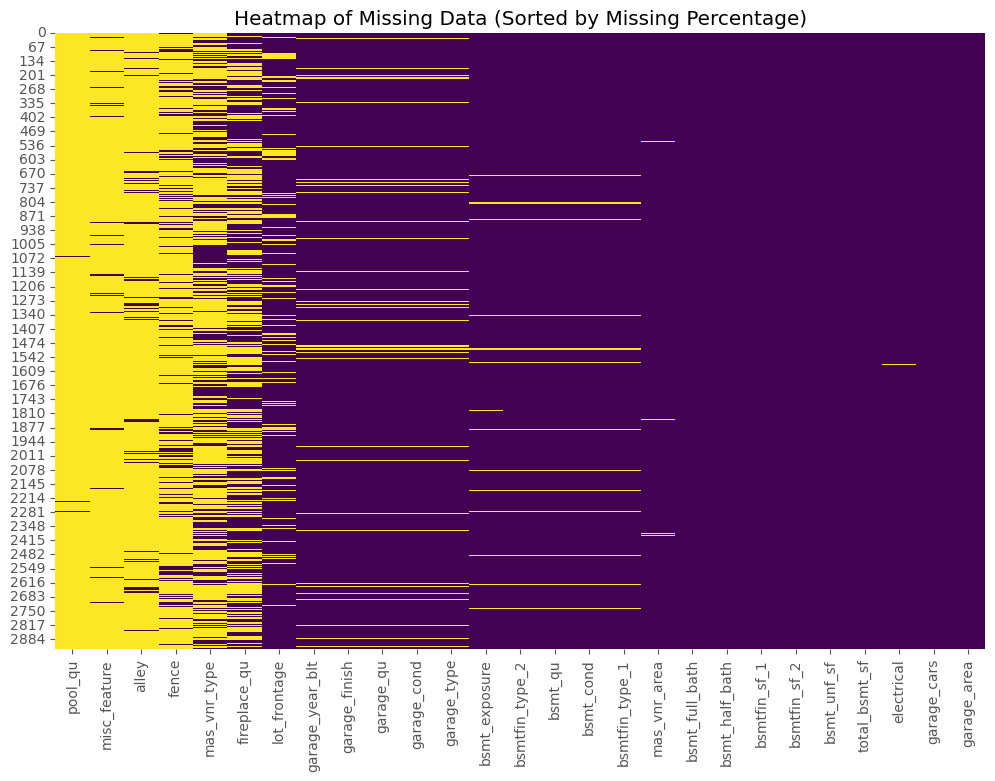

In [115]:
# Call the function to plot the heatmap
plot_missing_data_heatmap(df)

## Pool, Basement, Fireplace, Fence, Alley, Misc Features

Firstly, from the data dictionary, we know that 'NA' would imply No Pools! In fact, we can check this with the pool area.  

In [116]:
# Assert whether all pool_area values are 0 for missing pool_qu
assert (df[df['pool_qu'].isnull()]['pool_area'] == 0).all(), "Not all missing pool_qu have pool_area equal to 0"

In the dataset, missing values for variables such as `bsmt` (basement-related features) are represented by `NA`, indicating the absence of a basement. Similarly, `NA` values in variables like `fence`,`fireplace`, `alley` denote the absence of these respective features (e.g., no fence, no garage, no fireplace, and no alley access). Additionally, `NA` in the `misc_feature` variable signifies that no miscellaneous features are recorded for those entries. Then, the numerical features of corresponding areas are also missing and we will fill them in with 0. 

In [117]:
df = simple_fill_missing_by_keywords(df, ['pool', 'bsmt', 'fence', 'fireplace', 'alley', 'misc_feature'])

### Electrical

There is only one missing value for electrical. 

In [118]:
df[df['electrical'].isnull()][['ms_subclass', 'neighborhood', 'year_blt', 'street']]

,ms_subclass,neighborhood,year_blt,street
1577,80,Timber,2006,Pave


In [119]:
# Check for the type similar properties in the area as they tend to have the same electrical type
df[(df['ms_subclass'] == '80') & (df['neighborhood'] == "Timber")].groupby(['street', 'year_blt'])['electrical'].value_counts().unstack(fill_value=0)

,electrical
street,year_blt


All the buildings in the paved road access and `ms_subclass` (building class) and this Timber neighborhood all have SBrkr (Standard Circuit Breakers & Romex) as the electrical type. Therefore, it is reasonable to impute this missing value with SBrkr. 

In [120]:
# Fill missing electrical value with SBrkr based on similar properties in the area
df['electrical'] = df['electrical'].fillna('SBrkr')

### Garage

The column `garage_type` denotes 'No Garage' rather than 'NA' as when there is no garage but there are also NAs, and also the dictionary indicates that 'NA' for `garage_year_blt` can indicate missing garages. Here, we take a closer look at the garage type and area. 

In [121]:
consistency_missing_type_area(df, 'garage_area', 'garage_type')

{'percent_missing_area_zero': 100.0,
 'percent_missing_area_missing': 0.0,
 'percent_missing_area_other': 0.0}

In fact all the missing garage_type also have area zero so it means no garage. 

In [122]:
# Get missing garage info
garage_cols = df.columns[df.columns.str.contains('garage')]
missing_mask = df['garage_year_blt'].isnull()
missing = df.loc[missing_mask, garage_cols]
# Only either detached or no garage types for columns with missing year built. 
missing['garage_type'].value_counts(dropna=False), missing[missing['garage_type']=='Detchd'].head(2)

(garage_type
 NaN       157
 Detchd      2
 Name: count, dtype: int64,
      garage_type  garage_year_blt garage_finish  garage_cars  garage_area  \
 1356      Detchd              NaN           NaN          1.0        360.0   
 2236      Detchd              NaN           NaN          NaN          NaN   
 
      garage_qu garage_cond  
 1356       NaN         NaN  
 2236       NaN         NaN  )

In [123]:
# Only one observation where area is missing also.
df[df['garage_area'].isnull()][garage_cols]

,garage_type,garage_year_blt,garage_finish,garage_cars,garage_area,garage_qu,garage_cond
2236,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


Although the majority of missing values for areas and year built indeed stem from garage type being recorded as 'No Garage' to begin with. As we denote the lack of a facility as `NA` (non-applicable) in such cases, we may want to standarise this notations. 

This indicates some inconsistencies in the data recording. Although the garage type is Detached, no built years are recorded. One observation clearly has a garage area, while the later lacks everthing. In this case, we may fill in the `garage_year_blt` with the year built of the property. For where garage_area is missing, we will fill in with 0. For all the other finish, condition and quality columns, we may just keep 'NA' category (noting that this denotes either missing or not applicable), given that the non-easily-fillable missing values are too small to introduce another category

Now, check for inconsistencies in the year built and year sold if any houses are sold before they are built or fully remodelled. Furthermore, we check if any values are out of the range of the dataset 2006-2010. 

In [124]:
report_inconsistent_years(df, ['year_blt','year_remod/add' ,'garage_year_blt'], 'year_sold')

,year_blt,year_remod/add,garage_year_blt,year_sold
1702,2007,2008,2007.0,2007
2260,2006,2007,2207.0,2007


There is one observation that is built and one that is remodeled after it is sold. Additionally, there seems to be a typo for index 2260 in its `garage_year_blt`. However, it seems like the garage was build with remodelled and it was a typo from 2007 to 2207. We will fix this, while it is possible that a property is sold before it is built, we will not remove any observations. 

In [125]:
# Apply the imputer
df = garage_imputer(df)

### Masonry veneer type and area

In [126]:
# Call the function and print the results for 'mas_vnr_area' and 'mas_vnr_type'
consistency_missing_type_area(df, 'mas_vnr_area', 'mas_vnr_type')

{'percent_missing_area_zero': 98.30985915492958,
 'percent_missing_area_missing': 1.295774647887324,
 'percent_missing_area_other': 0.39436619718309857}

In [127]:
# Check for inconsistencies in masonry veneer data
print("\nBreakdown of mas_vnr_area values where mas_vnr_type is missing:")
df[df['mas_vnr_type'].isnull()]['mas_vnr_area'].value_counts().sort_index()


Breakdown of mas_vnr_area values where mas_vnr_type is missing:


mas_vnr_area
0.0      1745
1.0         3
285.0       1
288.0       1
312.0       1
344.0       1
Name: count, dtype: int64

In [128]:
# Show rows where mas_vnr_area is missing
df[df['mas_vnr_area'].isnull()][['mas_vnr_area', 'mas_vnr_type']]

,mas_vnr_area,mas_vnr_type
55,NaN,NaN
484,NaN,NaN
517,NaN,NaN
538,NaN,NaN
867,NaN,NaN
1095,NaN,NaN
1119,NaN,NaN
1122,NaN,NaN
1127,NaN,NaN
1184,NaN,NaN


Interestingly, for most where `mas_vnr_type` is missing, we observe that its area is 0. 1.2% of missing types has missing areas and  there is very small proportion where the area takes some other values. And for all where mas_vnr_area are missing, types are also missing. We will then impute all the missing `mas_vnr_type` with 'NA' and `mas_vnr_area` with 0. This can be done by simply adding 'mas_vnr' to the keywords when calling ``simple_fill_missing_by_keywords()``

In [129]:
df = simple_fill_missing_by_keywords(df, ['mas_vnr'])

### Lot Frontage

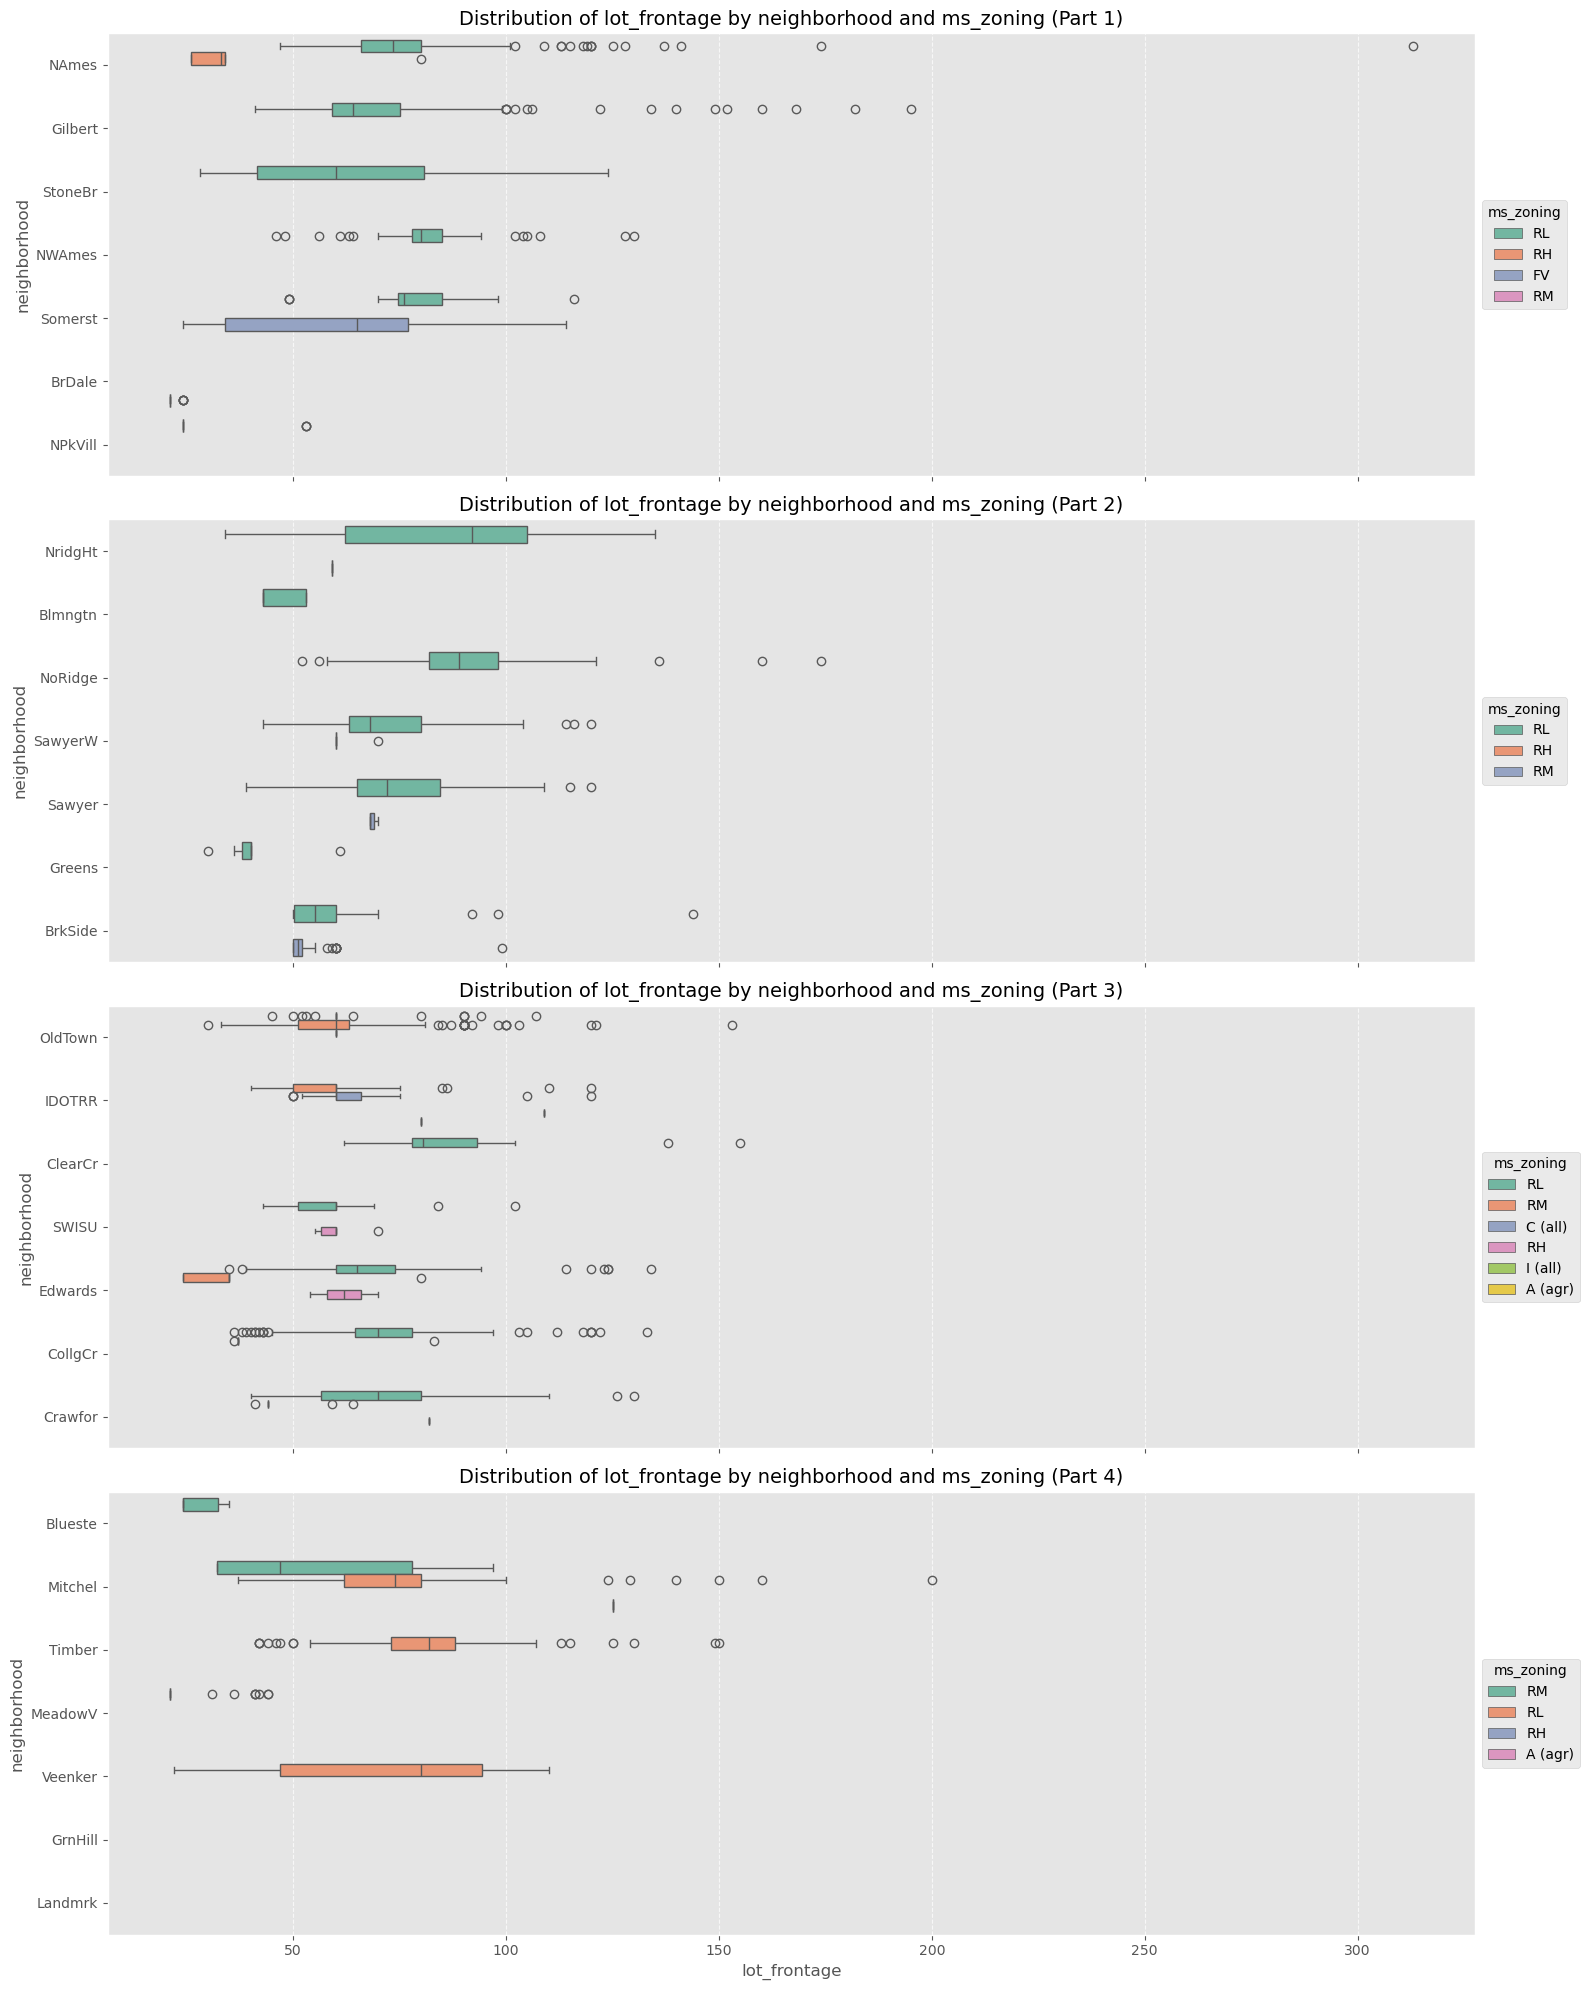

In [130]:
# Example usage
box_plot_dist(df, x='lot_frontage', y='neighborhood', hue='ms_zoning')

This shows that although there are some outliers based on the `lot_frontage` and `neighborhood`, it is not too bad in the sense that unless it is for the ms_zoning RM, RL (resiential areas with low to medium density) or FV (floating village residential), the distribution of `lot_frontage` is very concentrated. And even for those cases, the discrepancy are within 100 feet. We will then impute the missing values with the median of the `lot_frontage` of observations with the same `neighborhood` and `ms_zoning`. This imputer will better incorporated into the pipeline to avoid data leakage (i.e. only imputing for each train/test set separately).

#4. Feature Distribution

Feel free to select what you want to see. Give it 2-3 secs.

In [131]:
# Run the interactive plotting function
interactive_feature_distribution_plots(df, nominal, ordinal, continuous, discrete)

1. Most categorical features exhibit strong class imbalance, with one or two dominant categories.

2. For continuous features, measurements related to property size (`lot_frontage`, `lot_area`) and living spaces (room areas, garage areas) show right-skewed distributions with heavy tails. Other continuous variables tend to have a high concentration of zeros with extended right tails, suggesting that Box-Cox transformations may be beneficial if using GLM models to mitigate the impact of outliers.

3. For discrete features, we observe several notable patterns:
   a. The distributions of `garage_year_blt` and `year_blt` are remarkably similar, despite our imputation of 153 missing garage dates. This suggests our imputation strategy preserved the underlying temporal patterns.
   b. The distributions of full and half bathrooms show strong correlation, indicating potential redundancy. We could consider combining these into a single bathroom metric.
   c. Given the narrow time window of sales (2006-2010), calculating building age at sale may not add significant value. Instead, we can retain `year_blt` to capture the absolute age and consolidate `mo_sold` and `year_sold` into a single temporal variable.

Let's take a closer look at the sparsity of the categorical features. 

In [132]:
# Analyze categorical features
cat_analysis = analyze_categorical_sparsity(df, threshold_dominant=0.95, threshold_rare=0.01)
cat_analysis

,Feature,Unique Values,Most Common,Most Common %,Least Common,Least Common %,Has Dominant,Rare Categories
0,condition_2,8,Norm,99.009224,RRAn,0.034165,True,7
1,roof_matl,7,CompShg,98.565084,Metal,0.034165,True,6
2,heating,6,GasA,98.462590,Floor,0.034165,True,5
3,pool_qu,5,NA,99.590024,Fa,0.068329,True,4
4,misc_feature,5,NA,96.412709,TenC,0.034165,True,3
5,utilities,3,AllPub,99.897506,NoSeWa,0.034165,True,2
6,street,2,Pave,99.590024,Grvl,0.409976,True,1
7,land_slope,3,Gtl,95.182781,Sev,0.546635,True,1
8,neighborhood,28,NAmes,15.134950,Landmrk,0.034165,False,7
9,exterior_2nd,17,VinylSd,34.677144,Other,0.034165,False,7


Comment: This gives us a good overview of the sparsity of the categorical features. We may then consider adding infrequent categories for features where there are many possible values, existing a dominant feature and multiple categories falls short of the threshold of total observations (here we picked 1%): `condition_2`, `roof_matl`, `heating` (potentially only gas or non-gas).

#5. Features' Correlation with Target

Feel free to select what you want to see. Give it 2-3 secs.

In [133]:
interactive_feature_target_distribution_plots(df, nominal, ordinal, continuous, discrete, target_col='saleprice')

For discrete features, we can see that the patterns of `year_blt` and `year_remod/add` affecting the sale price in very similar way. Given that we have argued about the value of years built, we may consider using a dummy of the property ever been remodeled or not. And again, for the baths, we may consider using a variable for total number of baths instead.

For continuous features, total basement area `total_bsmt_sf` and `1st_flr_sf` have very similar relationship with the sale price. We may simply consider `total_bsmt_1st_flr_sf` as a single feature as opposed to that of the second floor. Finished and unfinished squared feet of basement area has slightly different effect, but that should link to the basement type and quality. 

For ordinal variable, it is not surprising that the overall quality  goes very well with the sale price. Indicators of facilities' qualities and conditions also goes as we expect for the monotonicity effect (higher quality, higher price). However, for `garage`, there are usually a switch among the top ones for rankings and seems like as long as it is a good enough garage, then it's fine for the buyer. 

For the nominal features, it is not surprising that the neighborhood and the type of the house (MSZoning) has a strong effect on the sale price. The first and second exterior covering on house also seems to have similar effect on house price, indicating the importance of the materials itself.

# 6. Closer look at categorical features

**ANOVA (Analysis of Variance)** is a statistical method used to assess the influence of categorical features on a continuous target variable by comparing the means of different groups.
1. Perform one-way ANOVA on each categorical feature to determine its effect on the target variable. This involves calculating the F-statistic, which is the ratio of the variance between group means to the variance within the groups.
2. Calculate the effect size (eta squared, η²) for each feature to quantify its impact. The formula for eta squared is η² = SS_between / SS_total, where SS_between is the sum of squares between groups and SS_total is the total sum of squares.
3. Identify and rank the top categorical features with the largest effect sizes for further analysis, focusing on those with the highest η² values.


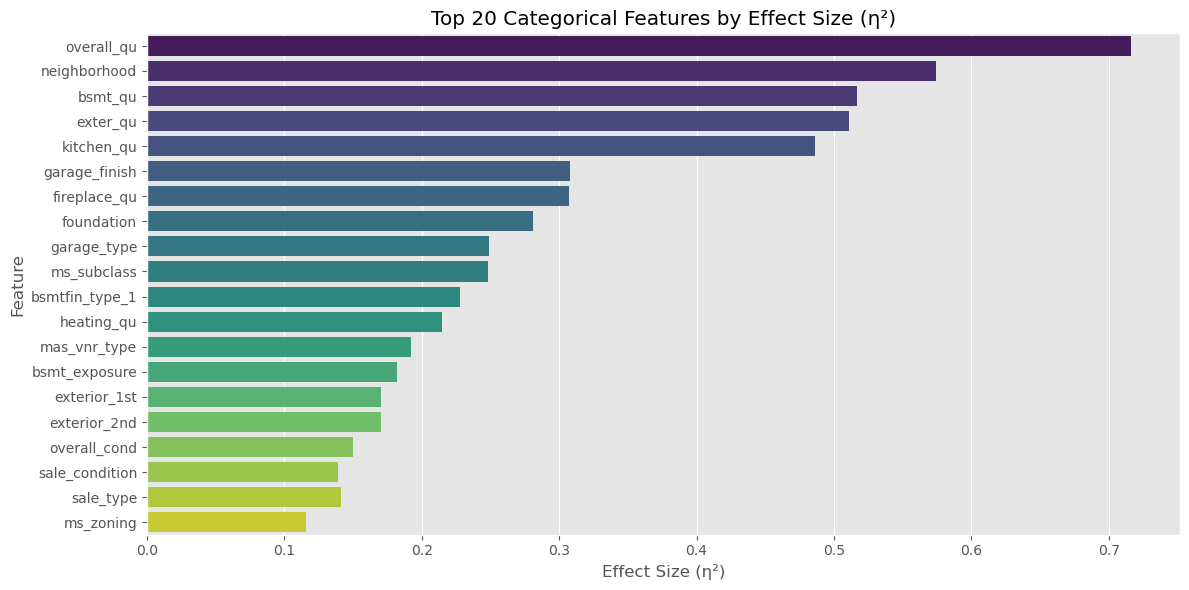

In [134]:
anova_categorical_feature_importance(df, nominal + ordinal, top_n=20)

Cramér's V is a measure of association between two nominal variables, giving a value between 0 and 1.
It is based on the chi-squared statistic and provides insight into the strength of the relationship between categorical features.
The formula for Cramér's V is:
V = sqrt(χ² / (n * (k - 1)))
where:
- χ² is the chi-squared statistic,
- n is the total number of observations,
- k is the minimum number of categories in either variable.

In the function `plot_cramer_v_associations`, we calculate Cramér's V for each pair of categorical features.
We first generate all possible pairs of categorical features and then compute the chi-squared statistic for each pair.
Using the chi-squared statistic, we calculate Cramér's V to measure the strength of association.
Finally, we plot the top 30 pairs with the highest Cramér's V values to visualize the strongest associations.

This measure helps identify pairs of categorical features that are strongly associated, which can be useful for feature engineering and reducing redundancy in the dataset.


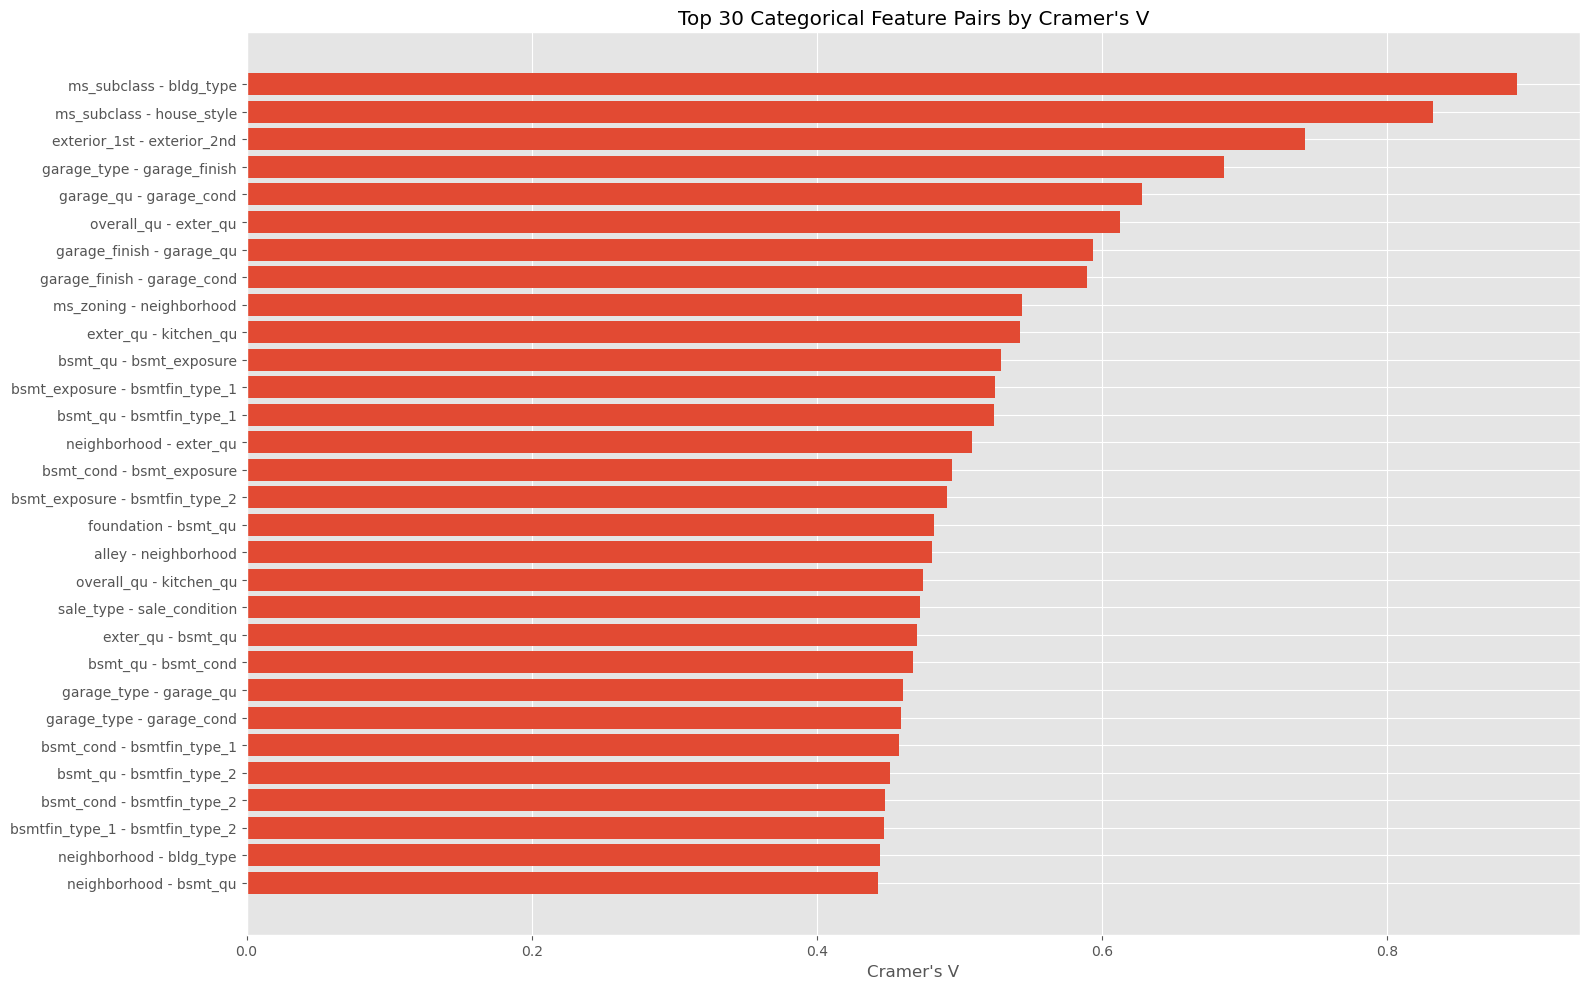

In [135]:
# Call function with combined categorical features
plot_cramer_v_associations(df, nominal + ordinal, top_n=30)

#### Observations and Insights

From the **Top 10 Categorical Features by Effect Size (η²)** chart, features like `overall_qu`, `neighborhood`, `bsmt_qu`, and `exter_qu` stand out with high explanatory power for the target variable. These features are likely critical for model performance.

The **Cramér's V analysis** highlights several strongly correlated pairs, such as `ms_subclass` with `bldg_type` or `house_style` (building class and building/house type). Given that `ms_subclass` is a useful feature, we may simply consider dropping the other two, as a simple understanding of the data shows that these tend to indicate the very same thing.

Similarly, we should consider `garage_type` with `garage_finish` as well as `garage_finish` with `garage_qu` and `garage_cond` (both of which are useful for predicting price). Hence, it is reasonable to consider dropping `garage_finish` for preliminary feature selection based on a simple understanding of what the variable tends to capture because `garage_finish` is just about the interior finish of the garage, which should already be captured in its quality. These correlations suggest possible redundancies, or some features on basement condition and quality with types are very highly correlated. We can use this for feature engineering and construct an aggregate measure instead of individually correlated ones.

Similarly, `bsmtfin_type_1` and `bsmtfin_type_2` are qualities of the basement finished area and are very correlated with `bsmt_qu`, `bsmt_cond`. Hence, we may consider dropping them as well, as they likely represent very similar things. Plus, we will already include numerical values on finished areas of the basement, so it should capture relevant information about the finished differentiation when already including overall basement quality and condition.

Though `neighbourhood` is a good feature and supposedly we always think that it will be for sure a factor to affect the price. However, it is clearly very correlated with the general zoning classification of the sale `mszoning` (i.e. it may not matter too much the neighbourhood name if it is a certain residential area), and it also correlates with quality of basement, exterior, kitchen, garage and foundation details of the building. Note that we have 28 neighbourhoods areas and it is possible that conditional on building types, access, just adding dummies for each neighbourhood will not be particularly useful. We can think of making a new feature based on neighbourhood maybe.

Let's take a closer look at `neighbourhood` and `mszoning`. 

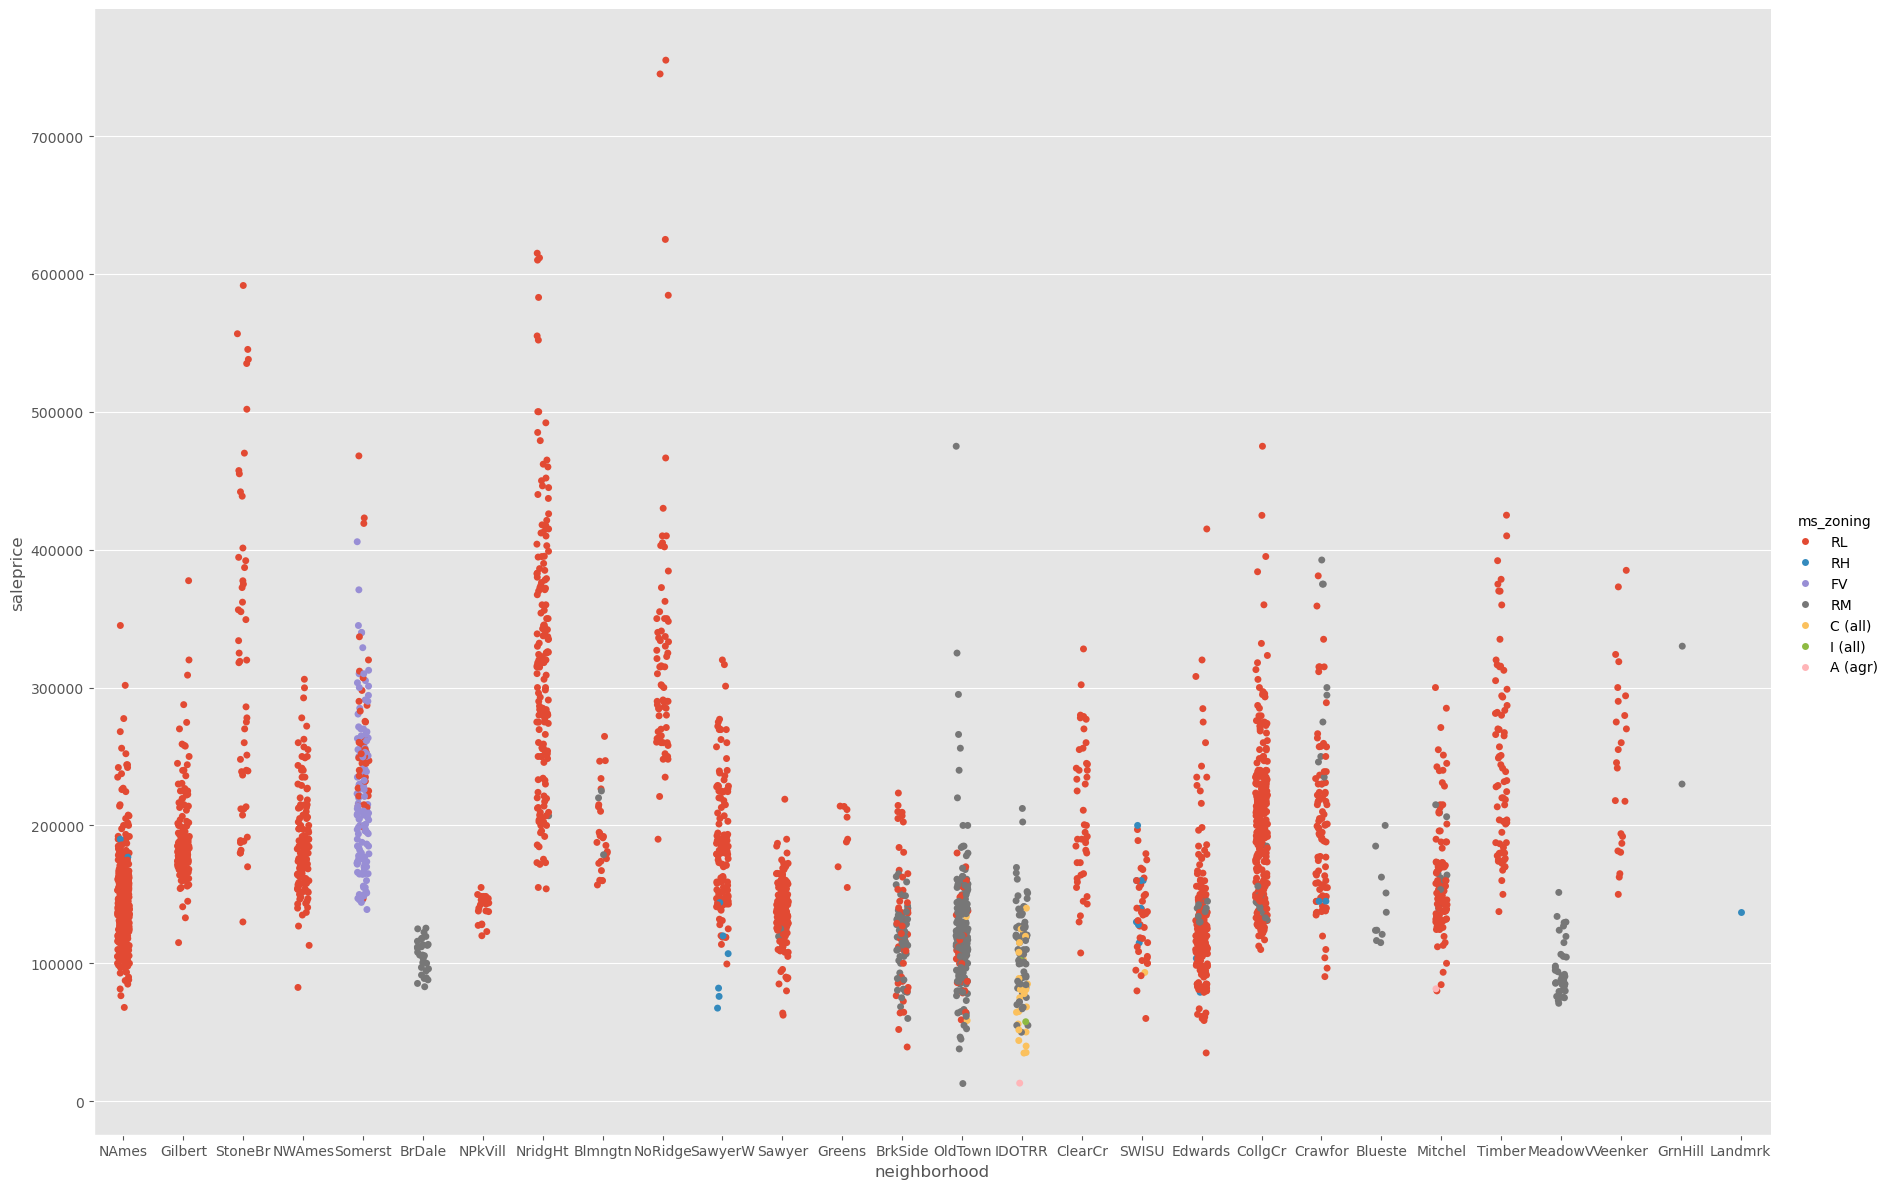

In [136]:
# Swarming Catplot FTW
fig = sns.catplot(x='neighborhood', y='saleprice', hue='ms_zoning', data=df, kind='strip', height=12, aspect=1.5)
ax = fig.axes[0][0]
plt.show()

It makes sense now that mszoning correlates a lot with neighbourhood because in it has residential area classified also based on population density with low to high, which should aready be part of the information contained in the neighbourhood itself. Therefore, given that we may keep the neighbourhood feature, we may consider aggregate 'RL', 'RH', 'RM' into one category of residential. 

# 7. Closer look at numerical features

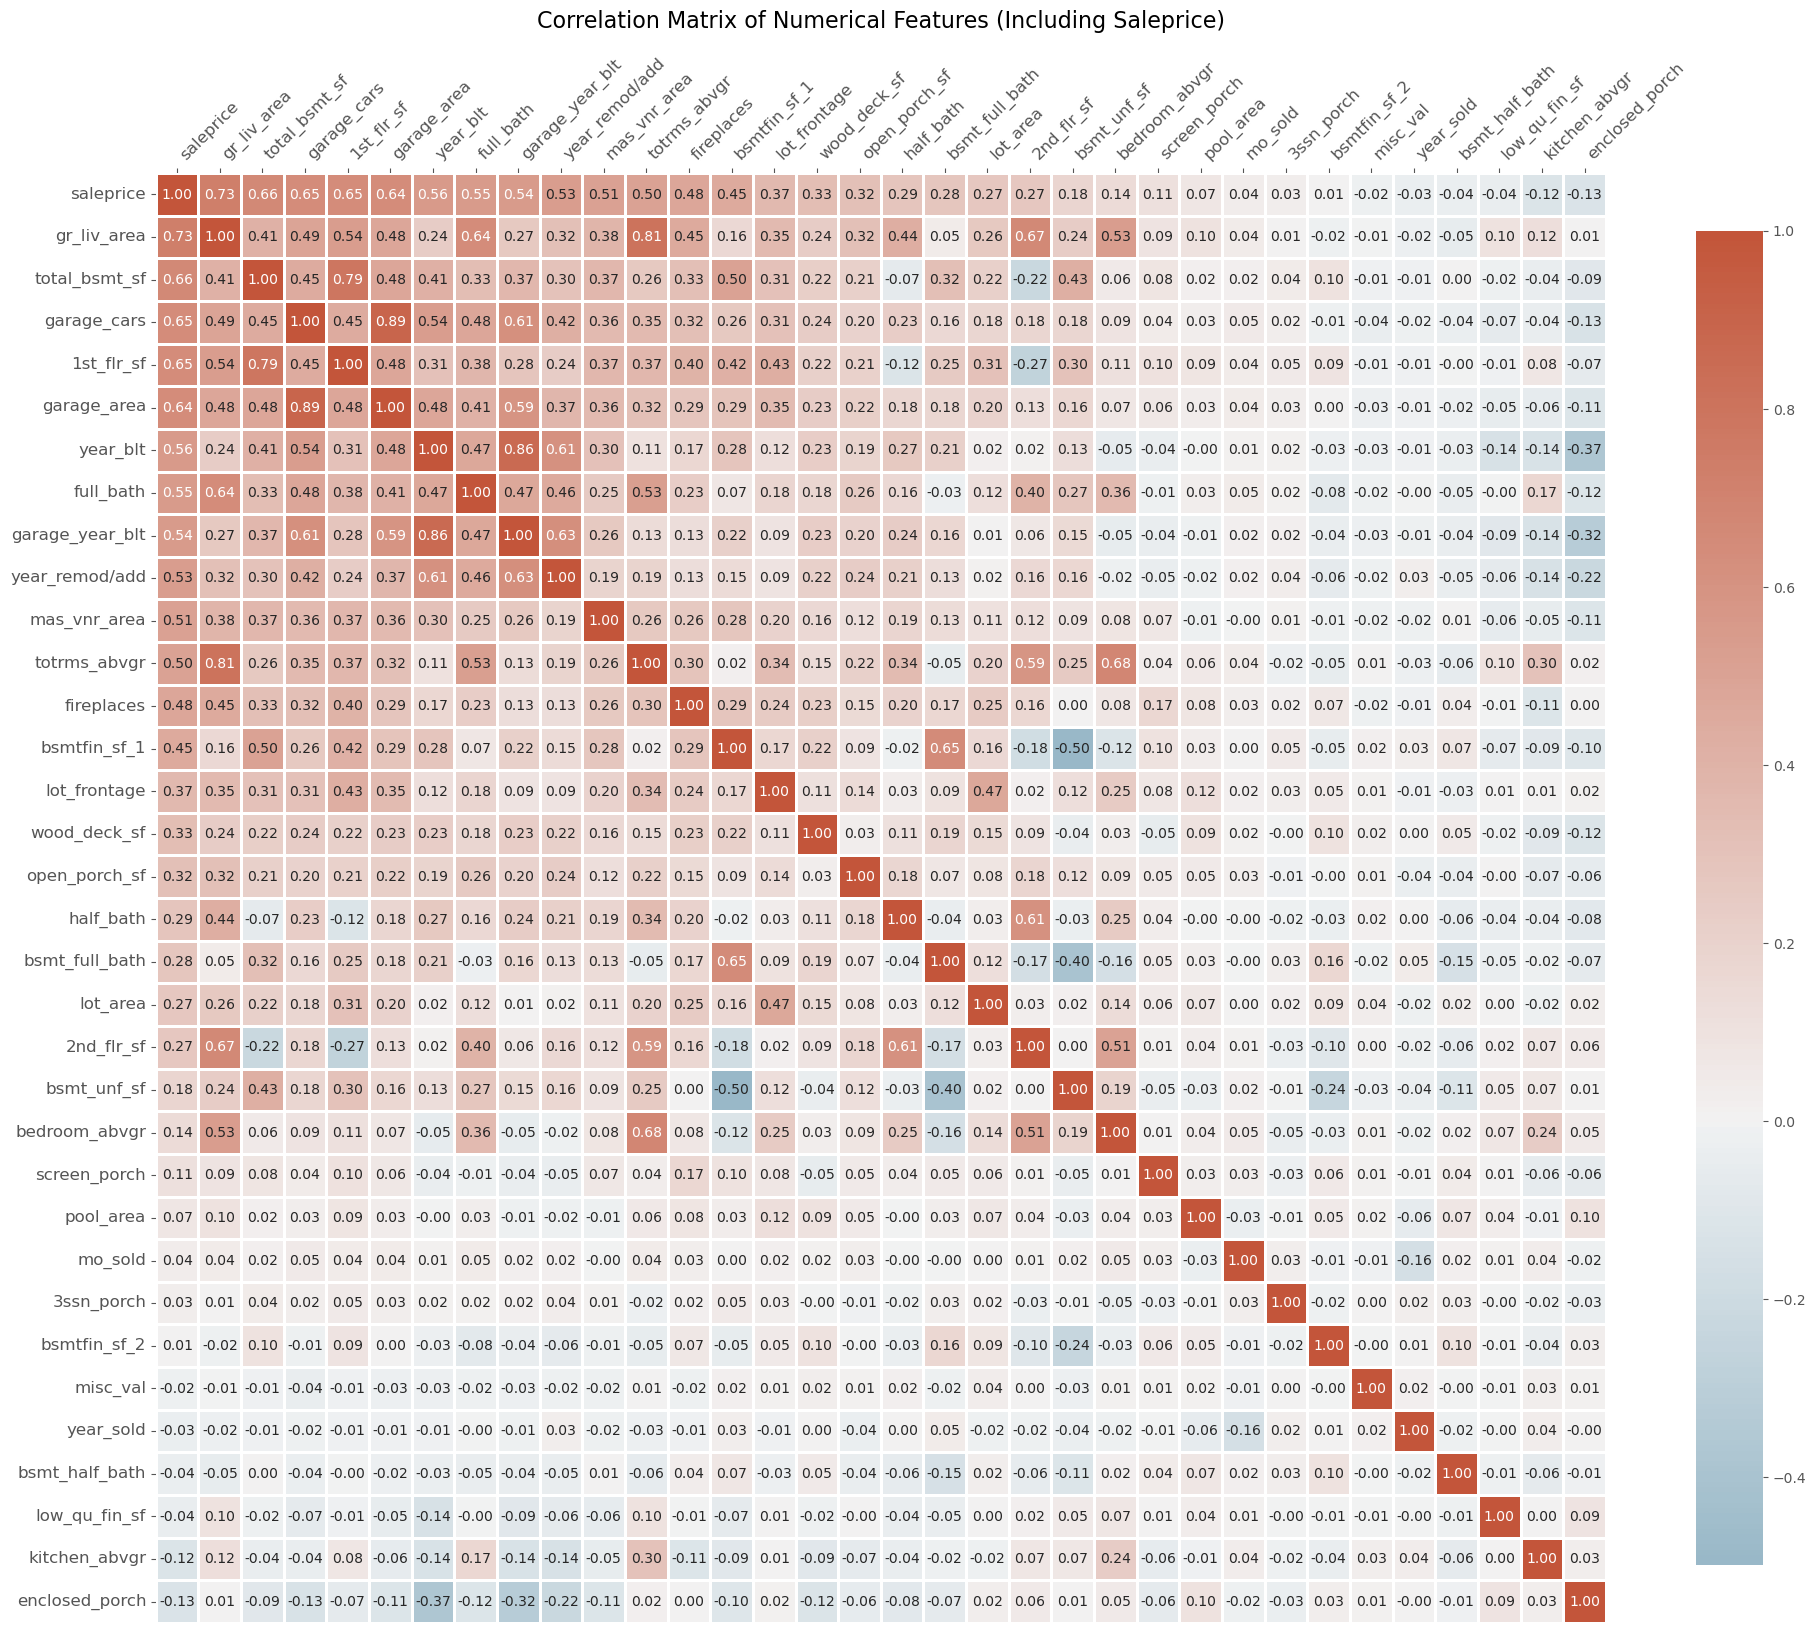

In [137]:
plot_numerical_correlation_matrix(df, target='saleprice', numerical_cols=continuous + discrete)

Features like gr_liv_area, total_bsmt_sf, garage_cars, garage_area, and 1st_flr_sf seem to have strong positive correlations with saleprice, but also very correlated with each other as they all indicate house size. Especially, `total_bsmt_sf` and `garage_area` would be highly correlated with each other, as total basement area and total garage area together. 

Suprisingly, `fullbath` (full bathrooms above grade) also very strongly correlated with `saleprice`, but also with living area. Unfinished square feet of basement area clearly will correlate very negatively with finished square feet of basement area `bsmt_fin_sf1`. 

Features like enclosed_porch, misc_val, and pool_area show negligible correlation. 

In [138]:
df['bsmt_exposure'].isnull().sum()

0

In [139]:
unique_bsmt_exposure = df['bsmt_exposure'].unique()
unique_bsmt_exposure

array(['Gd', 'No', 'Mn', 'Av', 'NA'], dtype=object)

In [141]:
# Load ordinal mappings from configuration


# Example usage
df_converted = type_formatting(
    df,
    discrete_cols=discrete,
    continuous_cols=continuous,
    nominal_cols=nominal,
    ordinal_cols=ordinal,
    ordinal_mappings=load_config().get("ordinal_mappings", [])
)
categorical_describer(df_converted, ordinal)



Categorical Columns Summary:
Total categorical columns: 23
Columns with missing values: 0


,Total Missing,Percent Missing,Data Type,Value Information,Mode,Mode Frequency
lot_shape,0,0.0,int64,"4 unique values: 1, 2, 3, 4",4,1859
heating_qu,0,0.0,int64,"5 unique values: 1, 2, 3, 4, 5",5,1492
pool_qu,0,0.0,int64,"5 unique values: 1, 2, 3, 4, 5",1,2915
paved_drive,0,0.0,int64,"3 unique values: 1, 2, 3",3,2649
garage_cond,0,0.0,int64,"6 unique values: 1, 2, 3, 4, 5, 6",2,2662
garage_qu,0,0.0,int64,"6 unique values: 1, 2, 3, 4, 5, 6",2,2612
garage_finish,0,0.0,int64,"4 unique values: 1, 2, 3, 4",2,1231
fireplace_qu,0,0.0,int64,"6 unique values: 1, 2, 3, 4, 5, 6",1,1422
functional,0,0.0,int64,"8 unique values: 1, 2, 3, 4, 5, 6, 7, 8",8,2725
kitchen_qu,0,0.0,int64,"5 unique values: 1, 2, 3, 4, 5",1,1494
